**Importing Libraries**

In [6]:
# Step 1: Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

**Loading dataset**

In [7]:
import pandas as pd
df = pd.read_csv('sentimentdataset.csv')
print(df.columns)
print(df.head())
print(df['Sentiment'].value_counts())


Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')
   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   Fitn

**Drop unnecessary columns**

In [8]:
df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)



**Clean data and Handle missing values**

In [9]:
# Clean whitespace and missing values
df['Sentiment'] = df['Sentiment'].astype(str).str.strip()
df['Text'] = df['Text'].astype(str).str.strip()
df.dropna(subset=['Text', 'Sentiment'], inplace=True)

**Normalize data**

In [10]:
# Normalize text
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\S+|#[A-Za-z0-9_]+", "", text)  # remove links, mentions, hashtags
    text = re.sub(r"[^a-z\s]", "", text)
    return text.strip()

df['Clean_Text'] = df['Text'].apply(clean_text)

**Sentiment Distribution**

/tmp/ipython-input-11-4175352151.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sentiments.values, y=top_sentiments.index, palette='viridis')


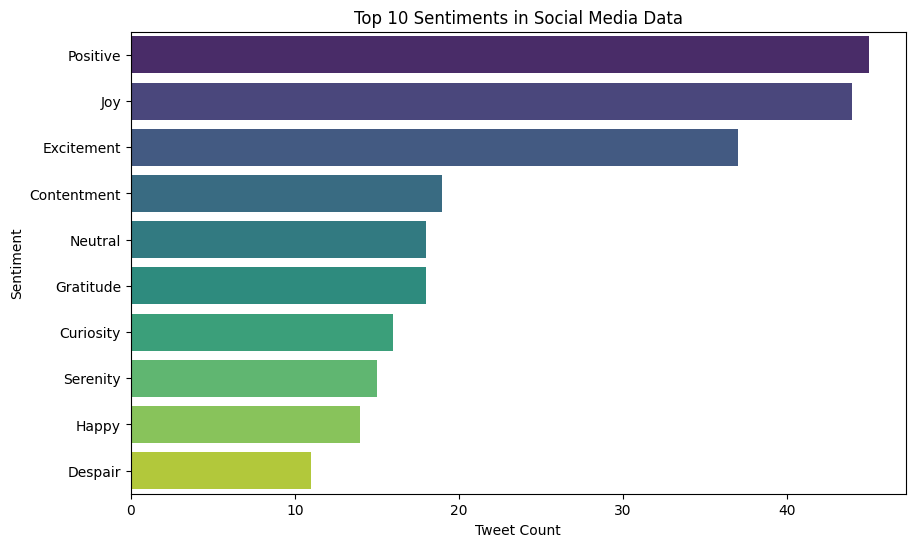

In [11]:
# Top 10 sentiments only
top_sentiments = df['Sentiment'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_sentiments.values, y=top_sentiments.index, palette='viridis')
plt.title('Top 10 Sentiments in Social Media Data')
plt.xlabel('Tweet Count')
plt.show()

- Positive and Joy are the most common sentiments, showing a generally upbeat mood on social media.

- Other active emotions include Excitement, Contentment, and Gratitude.

- Negative sentiments like Despair appear much less frequently.

- Overall, the sentiment tone is mostly positive and emotionally rich.



**Sentiment by Platform**

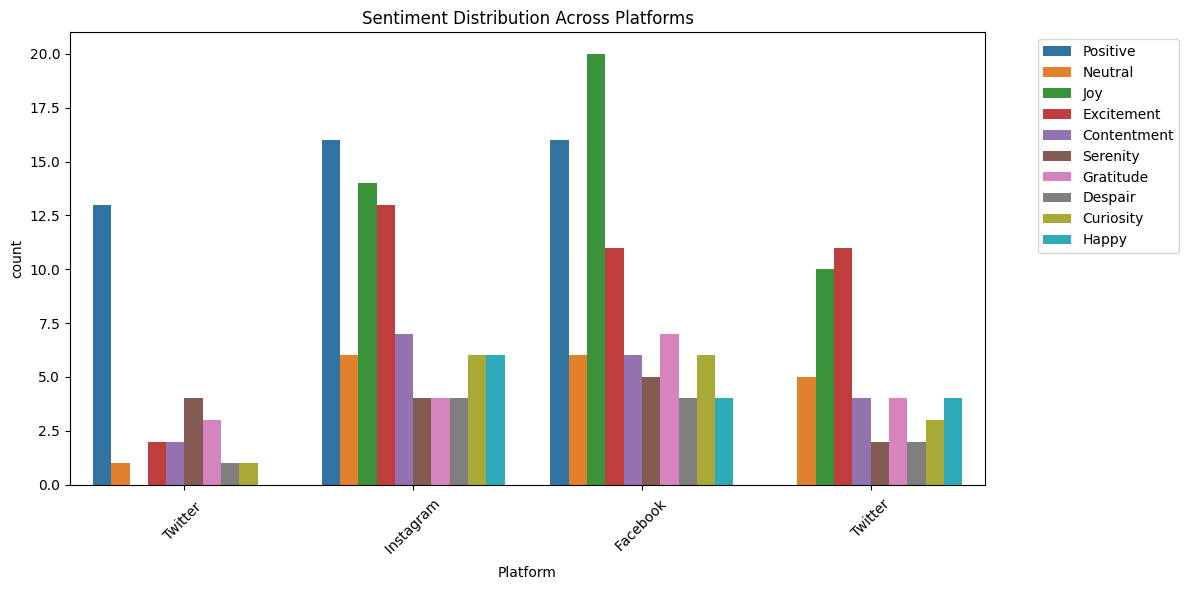

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(data=df[df['Sentiment'].isin(top_sentiments.index)],
              x='Platform', hue='Sentiment')
plt.title('Sentiment Distribution Across Platforms')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- Instagram has the most joyful and excited posts, reflecting its visual and lifestyle nature.

- Facebook shows a balanced mix, including some negative sentiments, indicating diverse personal sharing.

- Twitter displays a moderate spread but leans more toward informational or neutral content.

**Sentiment Over Time**

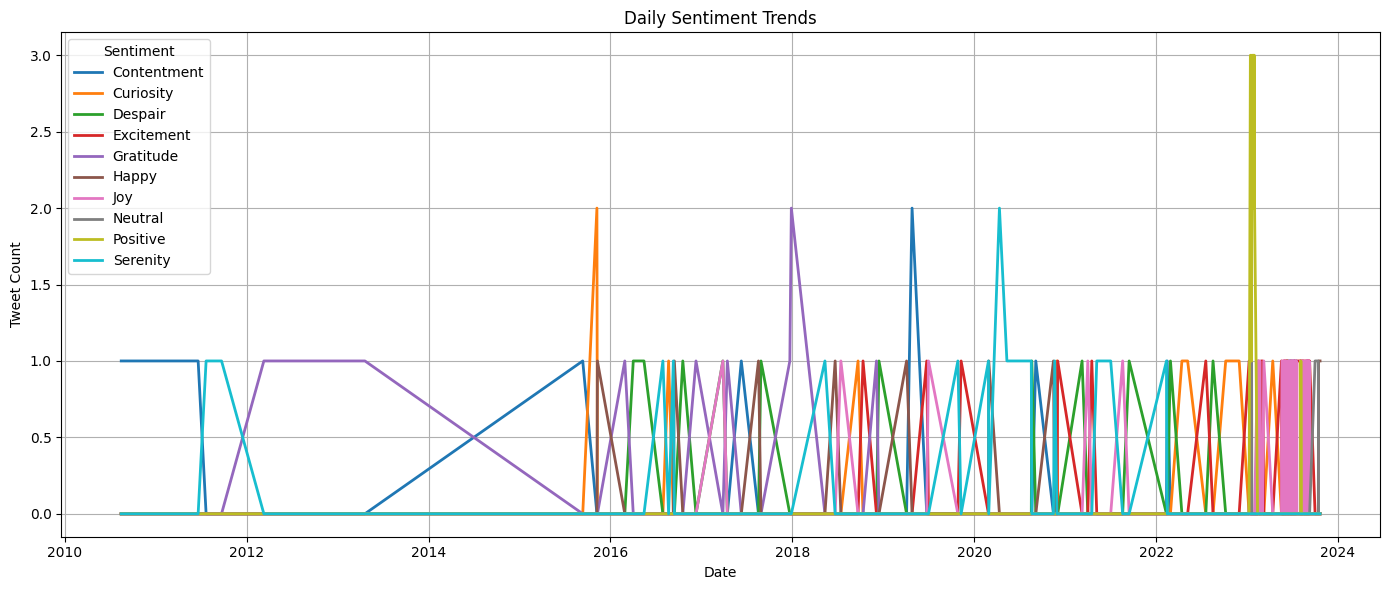

In [13]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date

# Top sentiments only
time_data = df[df['Sentiment'].isin(top_sentiments.index)]
sentiment_trend = time_data.groupby(['Date', 'Sentiment']).size().unstack().fillna(0)

sentiment_trend.plot(figsize=(14,6), linewidth=2)
plt.title('Daily Sentiment Trends')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.grid()
plt.tight_layout()
plt.show()


- Sentiments are sporadically distributed over time; no consistent long-term trend.

- Recent years (post-2020) show a slight increase in diversity of sentiments.

- Occasional spikes (e.g., Positive in 2023) may relate to specific events or viral content.

- Earlier years (2010–2015) had fewer and more limited sentiments posted.

**Engagement Metrics (Likes/Retweets)**

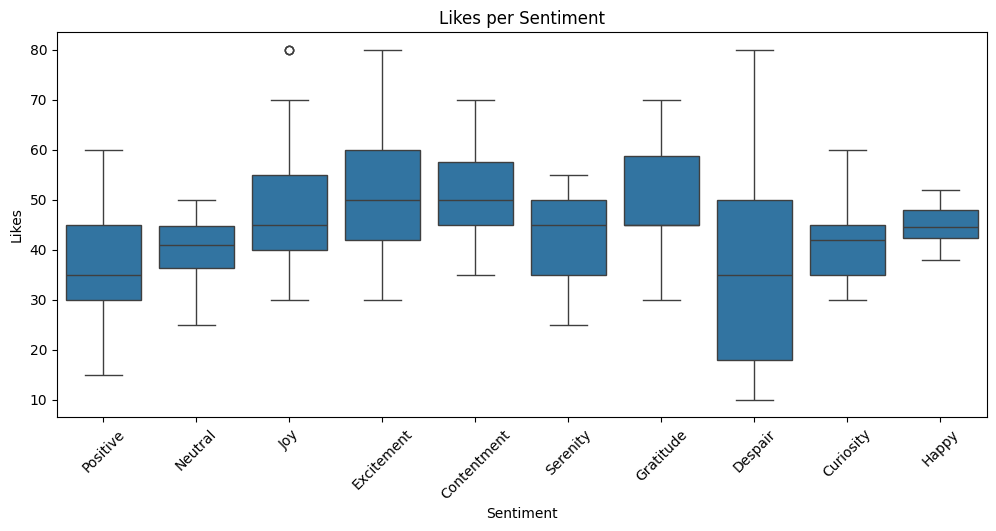

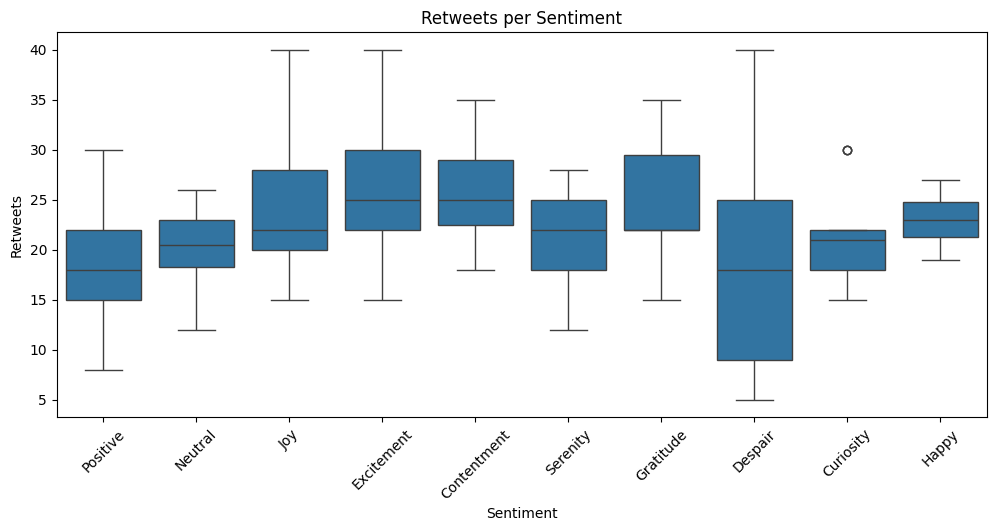

In [14]:
df[['Likes', 'Retweets']] = df[['Likes', 'Retweets']].fillna(0)

engage_df = df[df['Sentiment'].isin(top_sentiments.index)]

plt.figure(figsize=(12,5))
sns.boxplot(x='Sentiment', y='Likes', data=engage_df)
plt.title('Likes per Sentiment')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='Sentiment', y='Retweets', data=engage_df)
plt.title('Retweets per Sentiment')
plt.xticks(rotation=45)
plt.show()


🔼 Likes
- Gratitude, Excitement, and Joy receive the most likes on average.

- Despair shows the widest variation—some posts get very few likes, others go viral.

- Neutral and Positive posts tend to receive moderate engagement.

🔁 Retweets
- Excitement, Gratitude, and Joy again lead in retweet counts.

- Despair also has high potential for virality but with inconsistent spread.

- Contentment and Serenity perform well but not as widely shared.

**Word Clouds for Each Sentiment**

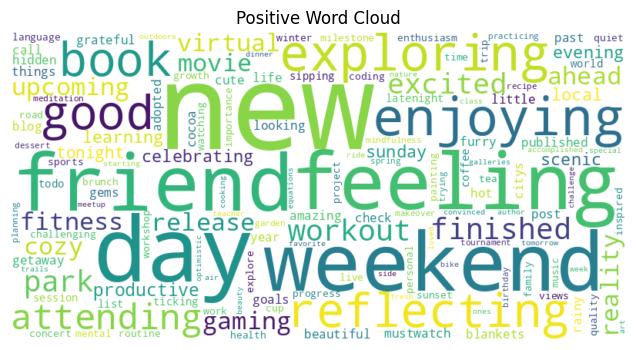

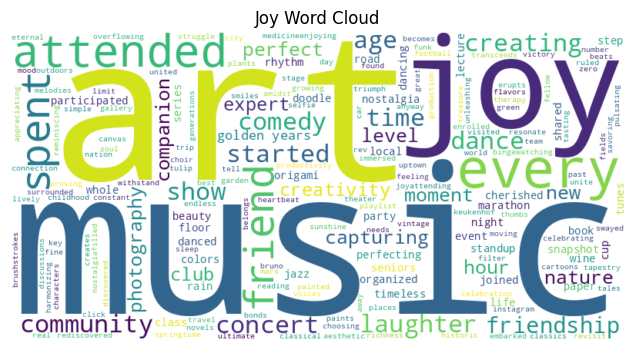

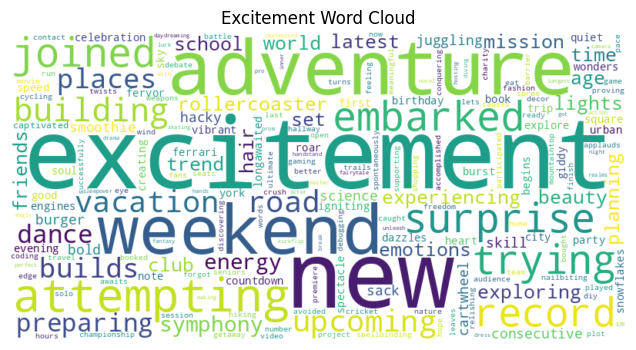

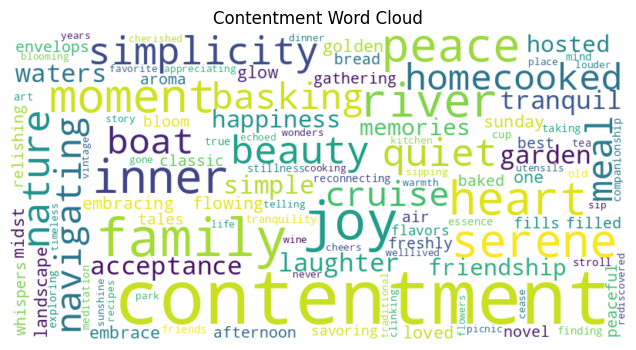

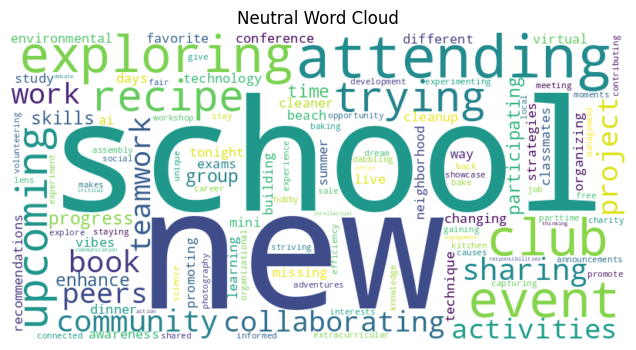

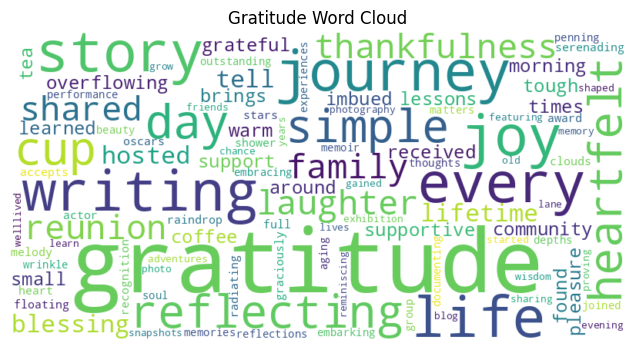

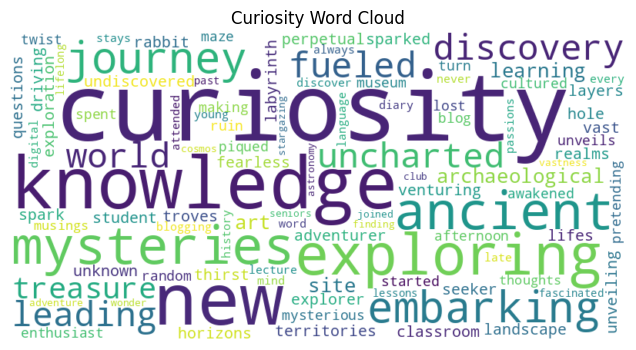

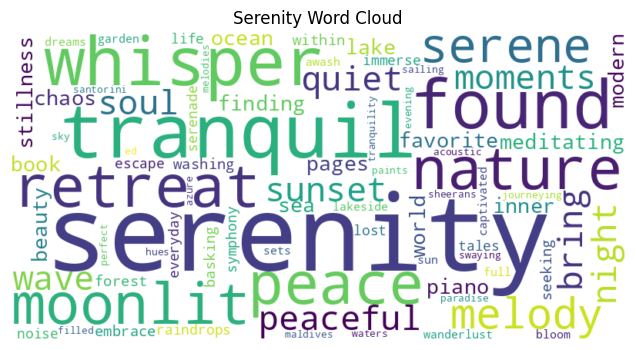

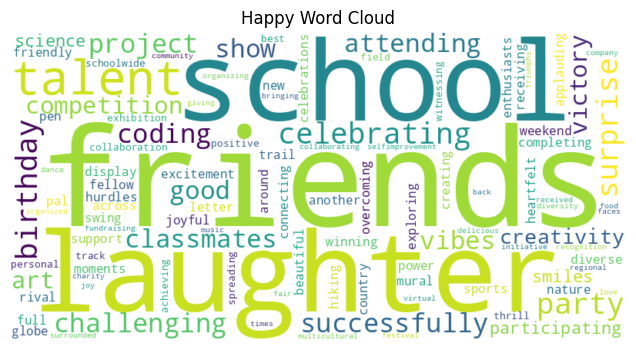

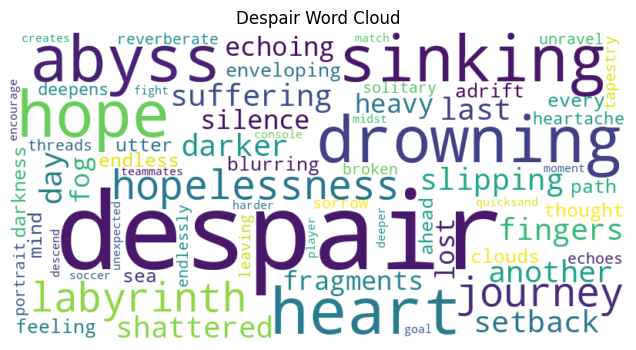

In [15]:
from wordcloud import WordCloud

for sentiment in top_sentiments.index:
    text = ' '.join(df[df['Sentiment'] == sentiment]['Clean_Text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment} Word Cloud')
    plt.show()


**Country vs Sentiment Heatmap**

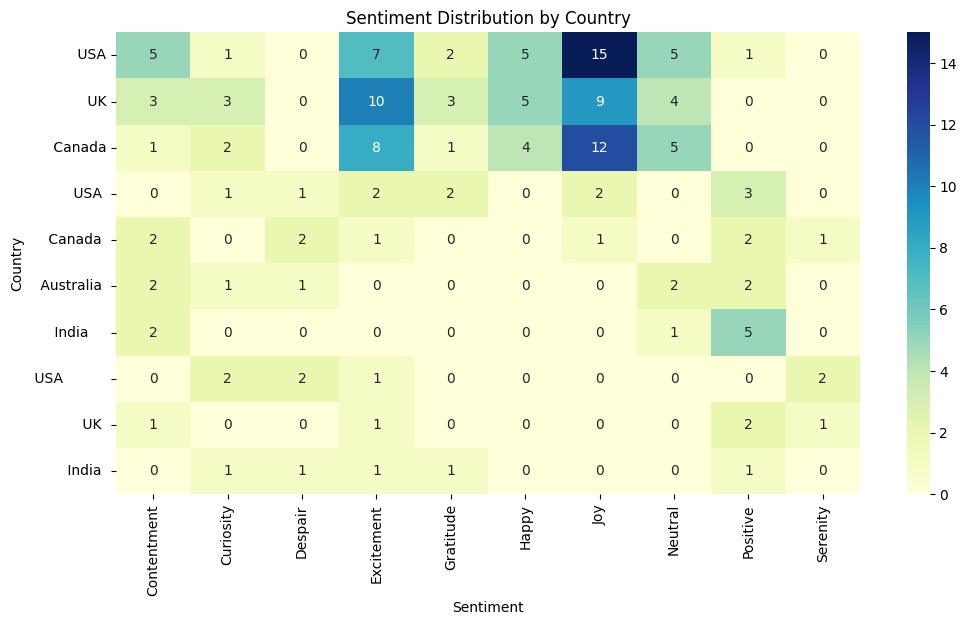

In [16]:
country_sentiment = df[df['Sentiment'].isin(top_sentiments.index)]
heat = country_sentiment.groupby(['Country', 'Sentiment']).size().unstack().fillna(0)
top_countries = heat.sum(axis=1).sort_values(ascending=False).head(10).index
heat = heat.loc[top_countries]

plt.figure(figsize=(12,6))
sns.heatmap(heat, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Sentiment Distribution by Country')
plt.ylabel('Country')
plt.xlabel('Sentiment')
plt.show()


- USA, UK, and Canada show the highest sentiment activity.

- "Joy" is the most common sentiment across these countries.

- India and Australia have lower sentiment counts.

- USA appears multiple times, possibly due to data filtering or duplication.